# Formula One Project: Data Preparation and EDA

DUE: November 22nd, 2024 (Fri)  
Name(s): Sean O'Connor, Connor Coles    
Class: CSCI 349 - Intro to Data Mining  
Semester: Fall 2024  
Instructor: Brian King  

## Assignment Description
Create your first notebook file, DataPrep_EDA.ipynb. Use both markdown and code cells to convey the following:
- What problem are you working on? Summarize in a single cell.
- What data are you using to understand the problem? Describe the data in a very general sense. Where did it come from? You should understand what every observation in the data represents, and what each variable represents.
- Remember that the key to achieving good machine learning outcomes is understanding how each real-world entity in your data will be represented as a fixed length vector of attributes in your dataset! Preprocessing your data will be a big part of this challenge. If you do not expect to spend quality time cleaning and prepping your data, you will not get good results. Once you have established how each data object is represented in a form ready for a data mining algorithm, and the data are clean, you will have a substantial part of your battle toward modeling solved.
- Strive to generate good summary statistics, show what the data looks like, and include good EDA and visualizations with boxplots, barcharts, density plots for key variables, or whatever other plots you want that are specific to your data and problem to help the reader understand basic distributions of important variables. Visualizations can help you convey general info about your data and are extremely helpful.
- In your final cells, discuss the modeling methods you expect to use. Start by clearly explaining if this is a classification, regression, clustering, or association rule mining problem? Justify. You have much of the framework to apply most algorithms, even those beyond what we covered in class. Feel free to explore different methods if you have good justification for doing so. If there are any papers of significance that have been published with these data, then discuss the ones most interesting/relevant to the team.
- Finally, what is your overarching aim with this project? What are you hoping to learn? Or, what hypothesis are you using the data to confirm or disprove? What challenges do you foresee on this project? Discuss your concerns. How will you get your work done? Give a reasonable list of milestones to reach to arrive at the final deadline for the project.

## Problem Statement
We are analyzing Formula One driver performance to understand and predict race outcomes based on various conditions. Specifically, we aim to:
1. Predict lap times based on weather and track conditions
2. Understand how different variables affect driver performance
3. Create models that can forecast race performance

This is primarily a regression problem, as we're predicting continuous values (lap times) based on multiple features.

In [1]:
# Importing Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

import fastf1
import fastf1.plotting
from fastf1.ergast.structure import FastestLap

In [2]:
# Set up FastF1 plotting and caching
cache_dir = '../data/cache'
if not os.path.exists(cache_dir):
    os.makedirs(cache_dir)

fastf1.Cache.enable_cache(cache_dir)
fastf1.plotting.setup_mpl(misc_mpl_mods=False, color_scheme=None)

In [3]:
# Define years, sessions, and events of interest
years = [2021, 2022, 2023, 2024]
sessions = ['Race']
events = ['Bahrain Grand Prix', 'British Grand Prix', 'Belgian Grand Prix', 'United States Grand Prix', 'Mexico City Grand Prix'] 

## Why these events, sessions, and years?

These events were chosen because they are all currently scheduled for the 2024 season, as well as having occurred in previous years. 

Each event has a specific set of conditions that may affect driver performance:
- Bahrain: Hot and humid, with high track temperatures
- British: Cool and changeable, with frequent rain
- Belgian: Overcast and cool, with frequent weather changes
- United States: Very hot, with high track temperatures
- Mexico City: Cool and changeable, with frequent rain

As for years, we chose 2021 to 2024 because they are the most recent years for which data is available. In 2021, the regulations changed to allow for more overtaking, so the lap times became incomparable to that of previous years.

We chose to only use the 'Race' session because it is the most representative of a race condition, as opposed to qualifying, which can be very sporadic.

In [4]:
# Get data from FastF1 API

# Data containers
weather_data_list = []
lap_data_list = []

# Loop through years and sessions
for year in years:
    for event_name in events:   
        for session_name in sessions:
            try:
                print(f"Processing {year} {event_name} - {session_name}")
                
                # Load the session
                session = fastf1.get_session(year, event_name, session_name, backend='fastf1')
                session.load()
                
                # Process weather data
                weather_data = session.weather_data
                if weather_data is not None:
                    weather_df = pd.DataFrame(weather_data)
                    # Add context columns
                    weather_df['Year'] = year
                    weather_df['Event'] = event_name
                    weather_df['Session'] = session_name
                    weather_data_list.append(weather_df)

                # Process lap data
                lap_data = session.laps
                if lap_data is not None:
                    lap_df = pd.DataFrame(lap_data)
                    # Add context columns
                    lap_df['Year'] = year
                    lap_df['Event'] = event_name
                    lap_df['Session'] = session_name
                    # Ensure driver information is included
                    if 'Driver' not in lap_df.columns:
                        lap_df['Driver'] = lap_df['DriverNumber'].map(session.drivers)
                    # Add team information if available
                    if 'Team' not in lap_df.columns:
                        lap_df['Team'] = lap_df['Driver'].map(session.drivers_info['TeamName'])
                    lap_data_list.append(lap_df)
        
            except Exception as e:
                print(f"Error with {event_name} {session_name} ({year}): {e}")

# Combine data into DataFrames
if weather_data_list:
    weather_data_combined = pd.concat(weather_data_list, ignore_index=True)
    # Ensure consistent column ordering
    weather_cols = ['Time', 'Year', 'Event', 'Session', 
                   'AirTemp', 'Humidity', 'Pressure', 'Rainfall', 
                   'TrackTemp', 'WindDirection', 'WindSpeed']
    weather_data_combined = weather_data_combined[weather_cols]
    print("\nWeather Data Structure:")
    print(weather_data_combined.info())

if lap_data_list:
    lap_data_combined = pd.concat(lap_data_list, ignore_index=True)
    # Ensure consistent column ordering
    lap_cols = ['Time', 'Year', 'Event', 'Session', 
                'Driver', 'Team', 'LapNumber', 'LapTime',
                'Sector1Time', 'Sector2Time', 'Sector3Time',
                'Compound', 'TyreLife', 'FreshTyre',
                'SpeedI1', 'SpeedI2', 'SpeedFL', 'SpeedST']
    # Only include columns that exist
    existing_cols = [col for col in lap_cols if col in lap_data_combined.columns]
    lap_data_combined = lap_data_combined[existing_cols]
    print("\nLap Data Structure:")
    print(lap_data_combined.info())

core           INFO 	Loading data for Bahrain Grand Prix - Race [v3.4.4]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...


Processing 2021 Bahrain Grand Prix - Race


req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['44', '33', '77', '4', '11', '16', '3', '55', '22', '18', '7', '99', '31', '63', '5', '47', '10', '6', '14', '9']
core           INFO 	Loading data for British Grand Prix - Race [v3.4.4]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...


Processing 2021 British Grand Prix - Race


req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['44', '16', '77', '4', '3', '55', '14', '18', '31', '22', '10', '63', '99', '6', '7', '11', '9', '47', '5', '33']
core           INFO 	Loading data for Belgian Grand Prix - Race [v3.4.4]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...


Processing 2021 Belgian Grand Prix - Race


req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['33', '63', '44', '3', '5', '10', '31', '16', '6', '55', '14', '77', '99', '4', '22', '47', '9', '7', '11', '18']
core           INFO 	Loading data for United States Grand Prix - Race [v3.4.4]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...


Processing 2021 United States Grand Prix - Race


core        WARNING 	Driver  7: Lap timing integrity check failed for 1 lap(s)
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['33', '44', '11', '16', '3', '77', '55', '4', '22', '5', '99', '18', '7', '63', '6', '47', '9', '14', '31', '10']
core           INFO 	Loading data for Mexico City Grand Prix - Race [v3.4.4]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Process

Processing 2021 Mexico City Grand Prix - Race


req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['33', '44', '11', '10', '16', '55', '5', '7', '14', '4', '99', '3', '31', '18', '77', '63', '6', '9', '47', '22']
core           INFO 	Loading data for Bahrain Grand Prix - Race [v3.4.4]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...


Processing 2022 Bahrain Grand Prix - Race


req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['16', '55', '44', '63', '20', '77', '31', '22', '14', '24', '47', '18', '23', '3', '4', '6', '27', '11', '1', '10']
core           INFO 	Loading data for British Grand Prix - Race [v3.4.4]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...


Processing 2022 British Grand Prix - Race


req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['55', '11', '44', '16', '14', '4', '1', '47', '5', '20', '18', '6', '3', '22', '31', '10', '77', '63', '24', '23']
core           INFO 	Loading data for Belgian Grand Prix - Race [v3.4.4]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...


Processing 2022 Belgian Grand Prix - Race


req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '11', '55', '63', '14', '16', '31', '5', '10', '23', '18', '4', '22', '24', '3', '20', '47', '6', '77', '44']
events      WARNING 	Correcting user input 'United States Grand Prix' to 'United States Grand Prix'
core           INFO 	Loading data for United States Grand Prix - Race [v3.4.4]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core

Processing 2022 United States Grand Prix - Race


req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '44', '16', '11', '63', '4', '14', '5', '20', '22', '31', '24', '23', '10', '47', '3', '6', '18', '77', '55']
core           INFO 	Loading data for Mexico City Grand Prix - Race [v3.4.4]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...


Processing 2022 Mexico City Grand Prix - Race


req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '44', '11', '63', '55', '16', '3', '31', '4', '77', '10', '23', '24', '5', '18', '47', '20', '6', '14', '22']
core           INFO 	Loading data for Bahrain Grand Prix - Race [v3.4.4]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...


Processing 2023 Bahrain Grand Prix - Race


req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '11', '14', '55', '44', '18', '63', '77', '10', '23', '22', '2', '20', '21', '27', '24', '4', '31', '16', '81']
core           INFO 	Loading data for British Grand Prix - Race [v3.4.4]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...


Processing 2023 British Grand Prix - Race


req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '4', '44', '81', '63', '11', '14', '23', '16', '55', '2', '77', '27', '18', '24', '22', '21', '10', '20', '31']
core           INFO 	Loading data for Belgian Grand Prix - Race [v3.4.4]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...


Processing 2023 Belgian Grand Prix - Race


req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '11', '16', '44', '14', '63', '4', '31', '18', '22', '10', '77', '24', '23', '20', '3', '2', '27', '55', '81']
events      WARNING 	Correcting user input 'United States Grand Prix' to 'United States Grand Prix'
core           INFO 	Loading data for United States Grand Prix - Race [v3.4.4]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
cor

Processing 2023 United States Grand Prix - Race


req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '4', '55', '11', '63', '10', '18', '22', '23', '2', '27', '77', '24', '20', '3', '14', '81', '31', '44', '16']
core           INFO 	Loading data for Mexico City Grand Prix - Race [v3.4.4]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...


Processing 2023 Mexico City Grand Prix - Race


req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '44', '16', '55', '4', '63', '3', '81', '23', '31', '10', '22', '27', '24', '77', '2', '18', '14', '20', '11']
core           INFO 	Loading data for Bahrain Grand Prix - Race [v3.4.4]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...


Processing 2024 Bahrain Grand Prix - Race


req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '11', '55', '16', '63', '4', '44', '81', '14', '18', '24', '20', '3', '22', '23', '27', '31', '10', '77', '2']
core           INFO 	Loading data for British Grand Prix - Race [v3.4.4]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...


Processing 2024 British Grand Prix - Race


req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['44', '1', '4', '81', '55', '27', '18', '14', '23', '22', '2', '20', '3', '16', '77', '31', '11', '24', '63', '10']
core           INFO 	Loading data for Belgian Grand Prix - Race [v3.4.4]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...


Processing 2024 Belgian Grand Prix - Race


req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['44', '81', '16', '1', '4', '55', '11', '14', '31', '3', '18', '23', '10', '20', '77', '22', '2', '27', '24', '63']
events      WARNING 	Correcting user input 'United States Grand Prix' to 'United States Grand Prix'
core           INFO 	Loading data for United States Grand Prix - Race [v3.4.4]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info


Processing 2024 United States Grand Prix - Race


req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['16', '55', '1', '4', '81', '63', '11', '27', '30', '43', '20', '10', '14', '22', '18', '23', '77', '31', '24', '44']
core           INFO 	Loading data for Mexico City Grand Prix - Race [v3.4.4]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info


Processing 2024 Mexico City Grand Prix - Race


req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['55', '4', '16', '44', '63', '1', '20', '81', '27', '10', '18', '43', '31', '77', '24', '30', '11', '14', '23', '22']



Weather Data Structure:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3364 entries, 0 to 3363
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype          
---  ------         --------------  -----          
 0   Time           3364 non-null   timedelta64[ns]
 1   Year           3364 non-null   int64          
 2   Event          3364 non-null   object         
 3   Session        3364 non-null   object         
 4   AirTemp        3364 non-null   float64        
 5   Humidity       3364 non-null   float64        
 6   Pressure       3364 non-null   float64        
 7   Rainfall       3364 non-null   bool           
 8   TrackTemp      3364 non-null   float64        
 9   WindDirection  3364 non-null   int64          
 10  WindSpeed      3364 non-null   float64        
dtypes: bool(1), float64(5), int64(2), object(2), timedelta64[ns](1)
memory usage: 266.2+ KB
None

Lap Data Structure:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19810 entries, 0 to 198

In [5]:
# Display some summary statistics, to ensure the data is correct
print("\nEvents per Year:")
print(lap_data_combined.groupby(['Year', 'Event']).size().unstack())

print("\nDrivers per Event:")
print(lap_data_combined.groupby(['Event', 'Driver']).size().unstack().notna().sum())

print("\nLaps per Driver:")
print(lap_data_combined.groupby('Driver')['LapNumber'].count().sort_values(ascending=False))


Events per Year:
Event  Bahrain Grand Prix  Belgian Grand Prix  British Grand Prix  \
Year                                                                
2021                 1028                  60                 970   
2022                 1125                 792                 815   
2023                 1056                 816                 971   
2024                 1129                 841                 961   

Event  Mexico City Grand Prix  United States Grand Prix  
Year                                                     
2021                     1261                      1044  
2022                     1379                       992  
2023                     1282                      1014  
2024                     1215                      1059  

Drivers per Event:
Driver
ALB    5
ALO    5
BOT    5
COL    2
DEV    2
GAS    5
GIO    5
HAM    5
HUL    5
LAT    5
LAW    2
LEC    5
MAG    5
MAZ    5
MSC    5
NOR    5
OCO    5
PER    5
PIA    5
RAI    5
RIC    5
RUS

In [6]:
weather_data_combined.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3364 entries, 0 to 3363
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype          
---  ------         --------------  -----          
 0   Time           3364 non-null   timedelta64[ns]
 1   Year           3364 non-null   int64          
 2   Event          3364 non-null   object         
 3   Session        3364 non-null   object         
 4   AirTemp        3364 non-null   float64        
 5   Humidity       3364 non-null   float64        
 6   Pressure       3364 non-null   float64        
 7   Rainfall       3364 non-null   bool           
 8   TrackTemp      3364 non-null   float64        
 9   WindDirection  3364 non-null   int64          
 10  WindSpeed      3364 non-null   float64        
dtypes: bool(1), float64(5), int64(2), object(2), timedelta64[ns](1)
memory usage: 266.2+ KB


In [7]:
weather_data_combined.head(5)

,Time,Year,Event,Session,AirTemp,Humidity,Pressure,Rainfall,TrackTemp,WindDirection,WindSpeed
0,0 days 00:00:43.040000,2021,Bahrain Grand Prix,Race,20.9,56.4,1014.8,False,29.9,6,1.0
1,0 days 00:01:43.040000,2021,Bahrain Grand Prix,Race,20.8,56.8,1014.8,False,29.9,8,1.1
2,0 days 00:02:43.040000,2021,Bahrain Grand Prix,Race,20.8,56.8,1014.7,False,30.2,11,1.0
3,0 days 00:03:43.039000,2021,Bahrain Grand Prix,Race,20.8,56.7,1014.8,False,30.2,7,1.0
4,0 days 00:04:43.041000,2021,Bahrain Grand Prix,Race,20.8,56.1,1014.8,False,29.9,0,0.9


In [8]:
weather_data_combined.describe()

,Time,Year,AirTemp,Humidity,Pressure,TrackTemp,WindDirection,WindSpeed
count,3364,3364.000000,3364.000000,3364.000000,3364.000000,3364.000000,3364.000000,3364.000000
mean,0 days 01:27:15.795649227,2022.415577,22.508621,49.090369,951.933859,34.621344,181.135553,1.495392
std,0 days 00:55:08.961025957,1.116340,5.135820,19.590571,86.575596,9.794653,111.188990,1.377857
min,0 days 00:00:05.091000,2021.000000,12.400000,16.000000,778.500000,14.500000,0.000000,0.000000
25%,0 days 00:42:08.192500,2021.000000,18.500000,36.000000,969.600000,28.100000,99.000000,0.600000
50%,0 days 01:24:10.835500,2022.000000,22.000000,49.000000,992.000000,35.100000,183.000000,1.100000
75%,0 days 02:06:13.047750,2023.000000,27.300000,59.000000,1006.700000,42.100000,286.000000,1.900000
max,0 days 04:49:16.818000,2024.000000,31.000000,97.500000,1017.500000,53.100000,359.000000,10.100000


In [9]:
lap_data_combined.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19810 entries, 0 to 19809
Data columns (total 18 columns):
 #   Column       Non-Null Count  Dtype          
---  ------       --------------  -----          
 0   Time         19810 non-null  timedelta64[ns]
 1   Year         19810 non-null  int64          
 2   Event        19810 non-null  object         
 3   Session      19810 non-null  object         
 4   Driver       19810 non-null  object         
 5   Team         19810 non-null  object         
 6   LapNumber    19810 non-null  float64        
 7   LapTime      19478 non-null  timedelta64[ns]
 8   Sector1Time  19338 non-null  timedelta64[ns]
 9   Sector2Time  19771 non-null  timedelta64[ns]
 10  Sector3Time  19773 non-null  timedelta64[ns]
 11  Compound     19810 non-null  object         
 12  TyreLife     19810 non-null  float64        
 13  FreshTyre    19810 non-null  bool           
 14  SpeedI1      17083 non-null  float64        
 15  SpeedI2      19775 non-null  float64

In [10]:
lap_data_combined.head(5)

,Time,Year,Event,Session,Driver,Team,LapNumber,LapTime,Sector1Time,Sector2Time,Sector3Time,Compound,TyreLife,FreshTyre,SpeedI1,SpeedI2,SpeedFL,SpeedST
0,0 days 00:39:14.871000,2021,Bahrain Grand Prix,Race,GAS,AlphaTauri,1.0,0 days 00:02:04.697000,NaT,0 days 00:00:56.543000,0 days 00:00:34.384000,MEDIUM,4.0,False,238.0,97.0,246.0,261.0
1,0 days 00:41:37.134000,2021,Bahrain Grand Prix,Race,GAS,AlphaTauri,2.0,0 days 00:02:22.263000,0 days 00:00:45.220000,0 days 00:01:00.086000,0 days 00:00:36.957000,MEDIUM,5.0,False,120.0,134.0,182.0,236.0
2,0 days 00:44:09.738000,2021,Bahrain Grand Prix,Race,GAS,AlphaTauri,3.0,NaT,0 days 00:00:42.591000,0 days 00:01:00.850000,0 days 00:00:49.169000,MEDIUM,6.0,False,217.0,99.0,176.0,229.0
3,0 days 00:46:16.510000,2021,Bahrain Grand Prix,Race,GAS,AlphaTauri,4.0,0 days 00:02:06.772000,0 days 00:00:33.336000,0 days 00:00:50.186000,0 days 00:00:43.250000,MEDIUM,7.0,False,229.0,202.0,NaN,297.0
4,0 days 00:48:28.044000,2021,Bahrain Grand Prix,Race,GAS,AlphaTauri,5.0,0 days 00:02:11.534000,0 days 00:01:05.748000,0 days 00:00:41.956000,0 days 00:00:23.830000,HARD,1.0,True,231.0,251.0,275.0,213.0


In [11]:
lap_data_combined.describe()

,Time,Year,LapNumber,LapTime,Sector1Time,Sector2Time,Sector3Time,TyreLife,SpeedI1,SpeedI2,SpeedFL,SpeedST
count,19810,19810.000000,19810.000000,19478,19338,19771,19773,19810.000000,17083.000000,19775.000000,19038.000000,17727.000000
mean,0 days 01:52:08.540997677,2022.564664,28.698486,0 days 00:01:38.341967604,0 days 00:00:31.143330178,0 days 00:00:40.651893935,0 days 00:00:27.420627926,12.823069,259.646842,233.138812,236.515075,301.719580
std,0 days 00:32:11.194678818,1.100844,17.318220,0 days 00:00:13.032210105,0 days 00:00:05.740951832,0 days 00:00:07.269305744,0 days 00:00:06.211696305,9.062348,45.762868,43.747139,33.113846,32.694864
min,0 days 00:39:08.419000,2021.000000,1.000000,0 days 00:01:17.774000,0 days 00:00:26.007000,0 days 00:00:29.991000,0 days 00:00:20.139000,1.000000,76.000000,40.000000,7.000000,65.000000
25%,0 days 01:25:39.044750,2022.000000,14.000000,0 days 00:01:30.654250,0 days 00:00:28.862000,0 days 00:00:36.303000,0 days 00:00:23.399000,6.000000,223.000000,185.000000,208.000000,295.000000
50%,0 days 01:51:00.233000,2023.000000,28.000000,0 days 00:01:37.846500,0 days 00:00:29.728000,0 days 00:00:40.783000,0 days 00:00:25.472000,11.000000,279.000000,250.000000,245.000000,304.000000
75%,0 days 02:16:05.674000,2024.000000,42.000000,0 days 00:01:43.256000,0 days 00:00:31.325000,0 days 00:00:42.779500,0 days 00:00:31.346000,18.000000,295.000000,265.000000,250.000000,320.000000
max,0 days 04:27:30.514000,2024.000000,71.000000,0 days 00:04:42.084000,0 days 00:01:38.794000,0 days 00:01:37.122000,0 days 00:01:39.664000,56.000000,357.000000,300.000000,297.000000,362.000000


## Data Description
Our data comes from the FastF1 API, which provides detailed Formula One racing data. Each observation represents a single lap during a race or qualifying session, including:

Key Variables:
- **Time**: Timestamp of the lap
- **Driver**: Driver identifier
- **LapTime**: Time taken to complete the lap
- **Weather Conditions**:
  - TrackTemp: Track temperature in Celsius
  - AirTemp: Air temperature in Celsius
  - Humidity: Percentage
  - Rainfall: Boolean indicating presence of rain
- **Performance Metrics**:
  - Sector times (1,2,3)
  - Speed measurements at various points
  - Compound: Tire compound used
  - TyreLife: Age of tires in laps

Each lap is represented as a fixed-length vector containing these attributes, making it suitable for machine learning algorithms.

## Data Preprocessing Steps
1. Time Conversion:
   - Converting lap times from timedelta to seconds
   - Standardizing timestamps for weather correlation

2. Missing Value Handling:
   - Removing incomplete laps
   - Handling missing weather data

3. Feature Engineering:
   - Creating derived features from raw data
   - Normalizing numerical values

4. Data Integration:
   - Merging weather and lap data
   - Ensuring temporal alignment of measurements

In [12]:
# Time conversion
# Function to convert timedelta to datetime
def convert_timedelta_to_datetime(df, base_date='2021-01-01'):
    if 'Time' in df.columns:
        # Create a base datetime and add the timedelta
        base = pd.Timestamp(base_date)
        if df['Time'].dtype == 'timedelta64[ns]':
            df['Time'] = base + df['Time']
    return df

# Apply conversion to both dataframes
weather_data_combined = convert_timedelta_to_datetime(weather_data_combined)
lap_data_combined = convert_timedelta_to_datetime(lap_data_combined)

In [13]:
# Verify the conversion
lap_data_combined.head(5)
weather_data_combined.head(5)

,Time,Year,Event,Session,AirTemp,Humidity,Pressure,Rainfall,TrackTemp,WindDirection,WindSpeed
0,2021-01-01 00:00:43.040,2021,Bahrain Grand Prix,Race,20.9,56.4,1014.8,False,29.9,6,1.0
1,2021-01-01 00:01:43.040,2021,Bahrain Grand Prix,Race,20.8,56.8,1014.8,False,29.9,8,1.1
2,2021-01-01 00:02:43.040,2021,Bahrain Grand Prix,Race,20.8,56.8,1014.7,False,30.2,11,1.0
3,2021-01-01 00:03:43.039,2021,Bahrain Grand Prix,Race,20.8,56.7,1014.8,False,30.2,7,1.0
4,2021-01-01 00:04:43.041,2021,Bahrain Grand Prix,Race,20.8,56.1,1014.8,False,29.9,0,0.9


In [14]:
# Missing value handling
# Are there any missing values?
print(weather_data_combined.isnull().sum())
print(lap_data_combined.isnull().sum())

Time             0
Year             0
Event            0
Session          0
AirTemp          0
Humidity         0
Pressure         0
Rainfall         0
TrackTemp        0
WindDirection    0
WindSpeed        0
dtype: int64
Time              0
Year              0
Event             0
Session           0
Driver            0
Team              0
LapNumber         0
LapTime         332
Sector1Time     472
Sector2Time      39
Sector3Time      37
Compound          0
TyreLife          0
FreshTyre         0
SpeedI1        2727
SpeedI2          35
SpeedFL         772
SpeedST        2083
dtype: int64


In [15]:
# Remove missing values
weather_data_combined = weather_data_combined.dropna()
lap_data_combined = lap_data_combined.dropna()

In [16]:
# Verify the drop
lap_data_combined.head(5)
weather_data_combined.head(5)

,Time,Year,Event,Session,AirTemp,Humidity,Pressure,Rainfall,TrackTemp,WindDirection,WindSpeed
0,2021-01-01 00:00:43.040,2021,Bahrain Grand Prix,Race,20.9,56.4,1014.8,False,29.9,6,1.0
1,2021-01-01 00:01:43.040,2021,Bahrain Grand Prix,Race,20.8,56.8,1014.8,False,29.9,8,1.1
2,2021-01-01 00:02:43.040,2021,Bahrain Grand Prix,Race,20.8,56.8,1014.7,False,30.2,11,1.0
3,2021-01-01 00:03:43.039,2021,Bahrain Grand Prix,Race,20.8,56.7,1014.8,False,30.2,7,1.0
4,2021-01-01 00:04:43.041,2021,Bahrain Grand Prix,Race,20.8,56.1,1014.8,False,29.9,0,0.9


In [17]:
# Feature engineering
# Create a new column for lap time in seconds
lap_data_combined['LapTime_seconds'] = lap_data_combined['LapTime'].dt.total_seconds()
# Display the first few rows of the updated DataFrame
lap_data_combined.head(5)

,Time,Year,Event,Session,Driver,Team,LapNumber,LapTime,Sector1Time,Sector2Time,Sector3Time,Compound,TyreLife,FreshTyre,SpeedI1,SpeedI2,SpeedFL,SpeedST,LapTime_seconds
1,2021-01-01 00:41:37.134,2021,Bahrain Grand Prix,Race,GAS,AlphaTauri,2.0,0 days 00:02:22.263000,0 days 00:00:45.220000,0 days 00:01:00.086000,0 days 00:00:36.957000,MEDIUM,5.0,False,120.0,134.0,182.0,236.0,142.263
4,2021-01-01 00:48:28.044,2021,Bahrain Grand Prix,Race,GAS,AlphaTauri,5.0,0 days 00:02:11.534000,0 days 00:01:05.748000,0 days 00:00:41.956000,0 days 00:00:23.830000,HARD,1.0,True,231.0,251.0,275.0,213.0,131.534
5,2021-01-01 00:50:04.721,2021,Bahrain Grand Prix,Race,GAS,AlphaTauri,6.0,0 days 00:01:36.677000,0 days 00:00:30.990000,0 days 00:00:41.802000,0 days 00:00:23.885000,HARD,2.0,True,233.0,254.0,275.0,280.0,96.677
6,2021-01-01 00:51:41.675,2021,Bahrain Grand Prix,Race,GAS,AlphaTauri,7.0,0 days 00:01:36.954000,0 days 00:00:31.176000,0 days 00:00:41.678000,0 days 00:00:24.100000,HARD,3.0,True,232.0,252.0,274.0,282.0,96.954
8,2021-01-01 00:54:56.129,2021,Bahrain Grand Prix,Race,GAS,AlphaTauri,9.0,0 days 00:01:37.030000,0 days 00:00:31.256000,0 days 00:00:41.911000,0 days 00:00:23.863000,HARD,5.0,True,234.0,248.0,276.0,286.0,97.030


In [18]:
# Data integration
# Merge weather and lap data on time and event
# First, let's check our data before merging
print("Weather Data Shape:", weather_data_combined.shape)
print("Lap Data Shape:", lap_data_combined.shape)

print("\nWeather Data Columns:")
print(weather_data_combined.columns.tolist())
print("\nLap Data Columns:")
print(lap_data_combined.columns.tolist())

# Check the time ranges in both datasets
print("\nWeather Data Time Range:")
print("Start:", weather_data_combined['Time'].min())
print("End:", weather_data_combined['Time'].max())

print("\nLap Data Time Range:")
print("Start:", lap_data_combined['Time'].min())
print("End:", lap_data_combined['Time'].max())

# Merge the data
merged_data = pd.merge_asof(
    lap_data_combined.sort_values('Time'),
    weather_data_combined.sort_values('Time'),
    on='Time',
    by=['Event', 'Year'],  # Match within same event and year
    direction='nearest',
    tolerance=pd.Timedelta('1 min')  # Allow matching within 1 minute
)

print("\nMerged Data Shape:", merged_data.shape)
print("\nSample of merged data:")
print(merged_data.head())

Weather Data Shape: (3364, 11)
Lap Data Shape: (14238, 19)

Weather Data Columns:
['Time', 'Year', 'Event', 'Session', 'AirTemp', 'Humidity', 'Pressure', 'Rainfall', 'TrackTemp', 'WindDirection', 'WindSpeed']

Lap Data Columns:
['Time', 'Year', 'Event', 'Session', 'Driver', 'Team', 'LapNumber', 'LapTime', 'Sector1Time', 'Sector2Time', 'Sector3Time', 'Compound', 'TyreLife', 'FreshTyre', 'SpeedI1', 'SpeedI2', 'SpeedFL', 'SpeedST', 'LapTime_seconds']

Weather Data Time Range:
Start: 2021-01-01 00:00:05.091000
End: 2021-01-01 04:49:16.818000

Lap Data Time Range:
Start: 2021-01-01 00:41:30.825000
End: 2021-01-01 03:20:47.648000

Merged Data Shape: (14238, 27)

Sample of merged data:
                     Time  Year               Event Session_x Driver  \
0 2021-01-01 00:41:30.825  2021  Bahrain Grand Prix      Race    VER   
1 2021-01-01 00:41:32.424  2021  Bahrain Grand Prix      Race    HAM   
2 2021-01-01 00:41:34.055  2021  Bahrain Grand Prix      Race    LEC   
3 2021-01-01 00:41:35.42

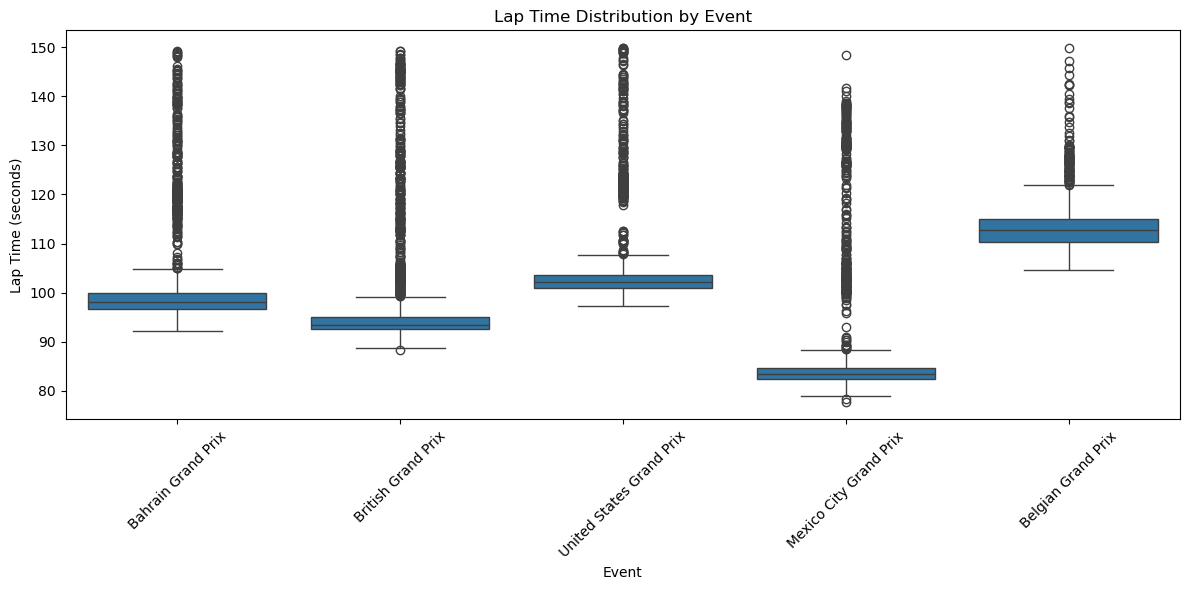

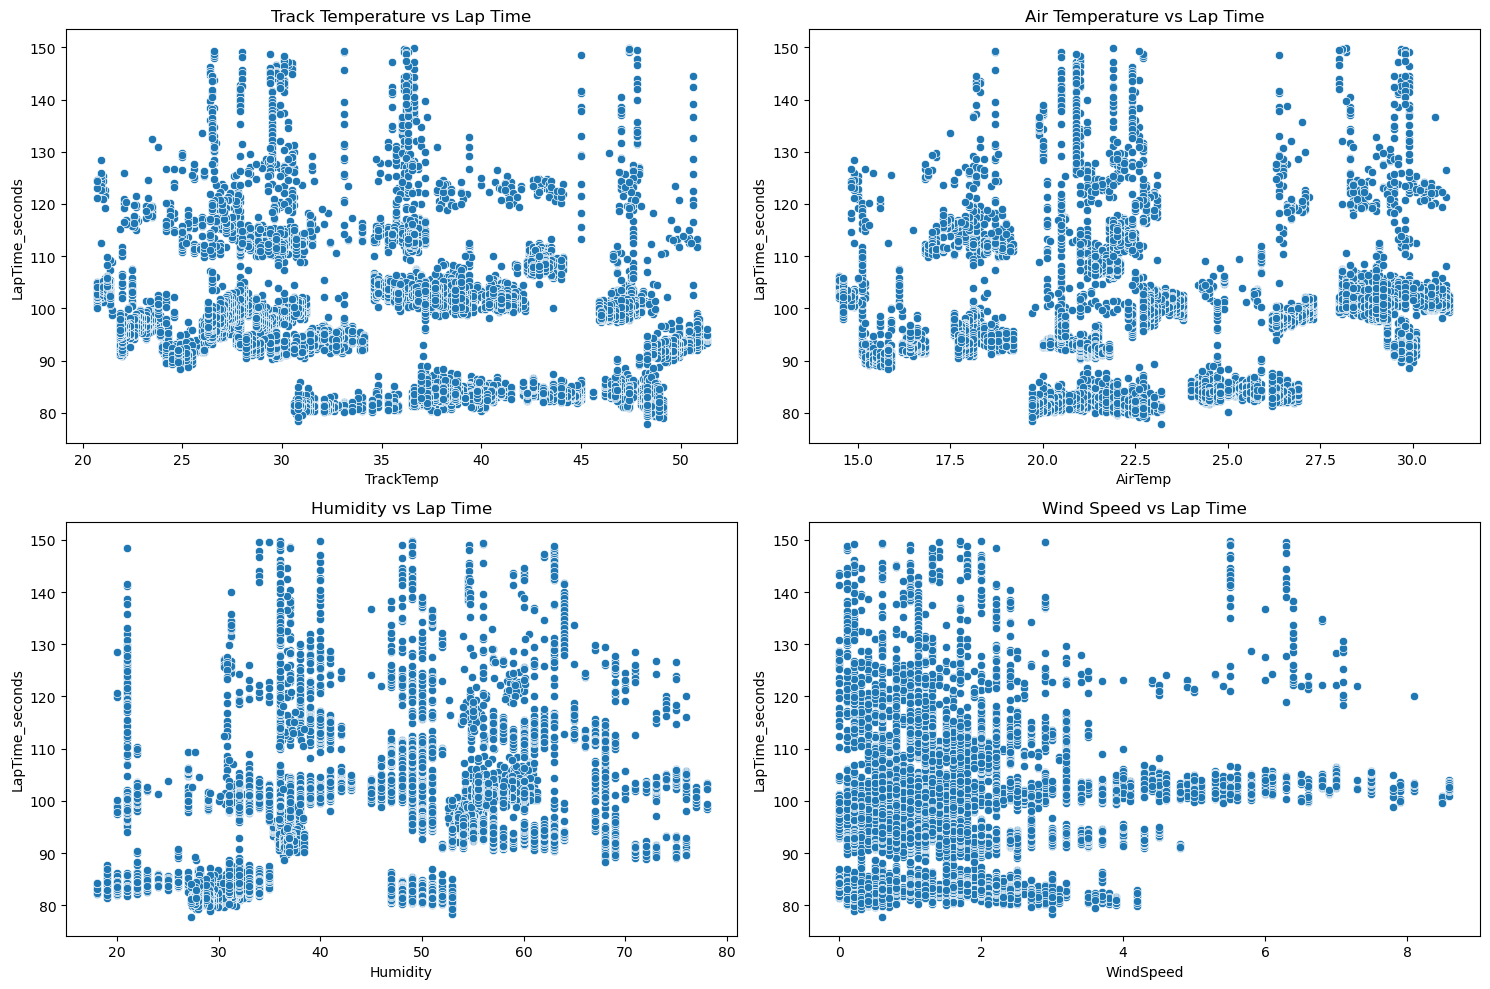

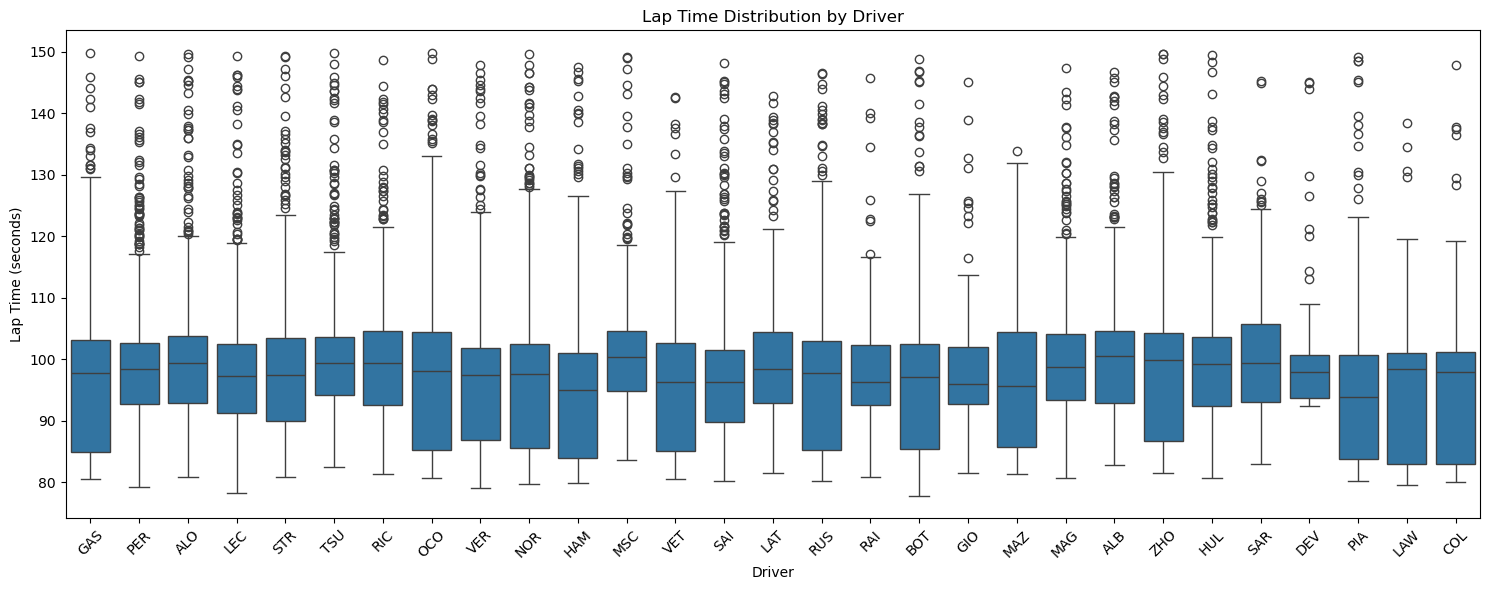

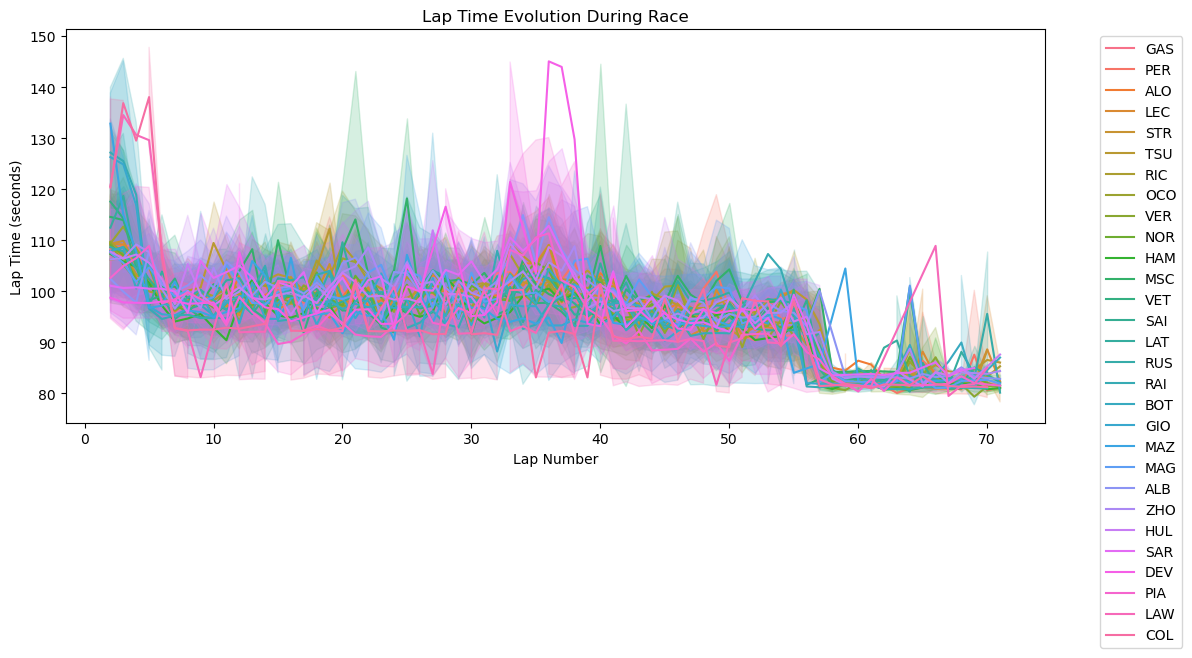

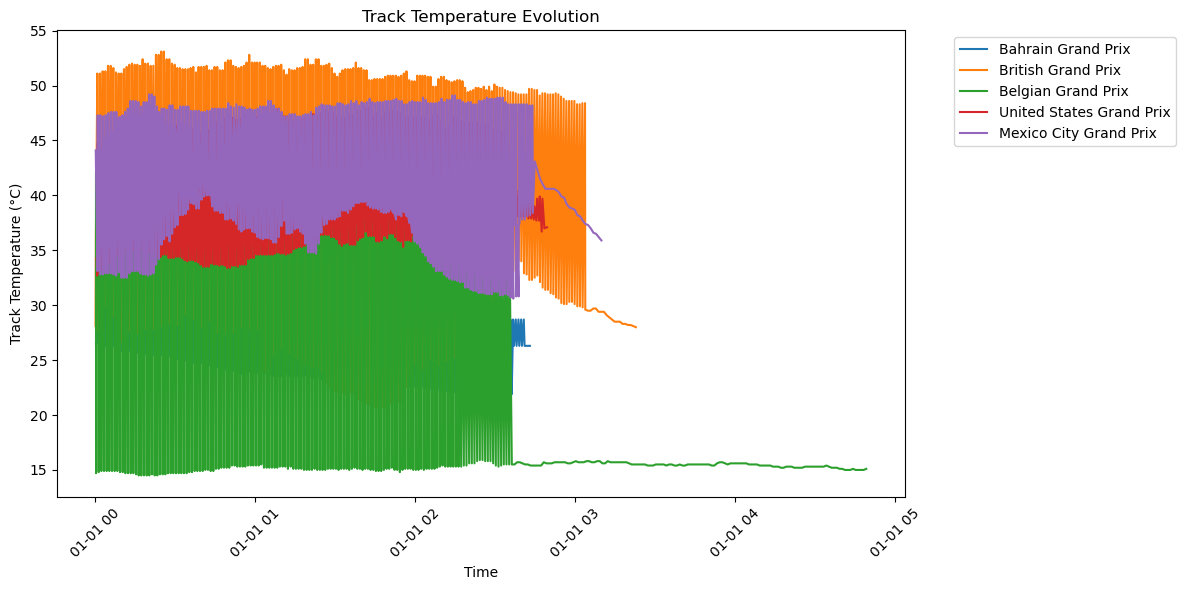

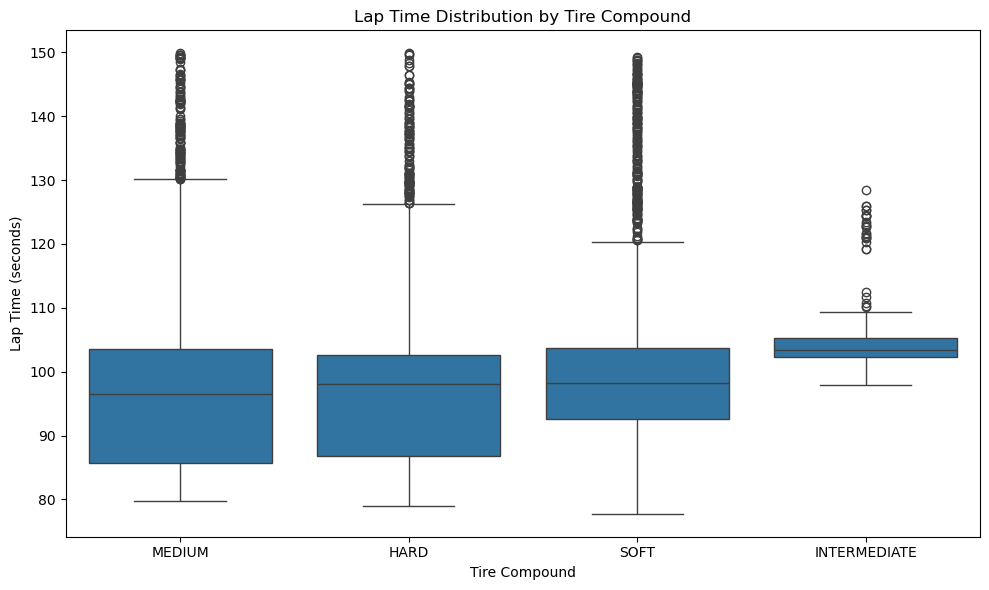

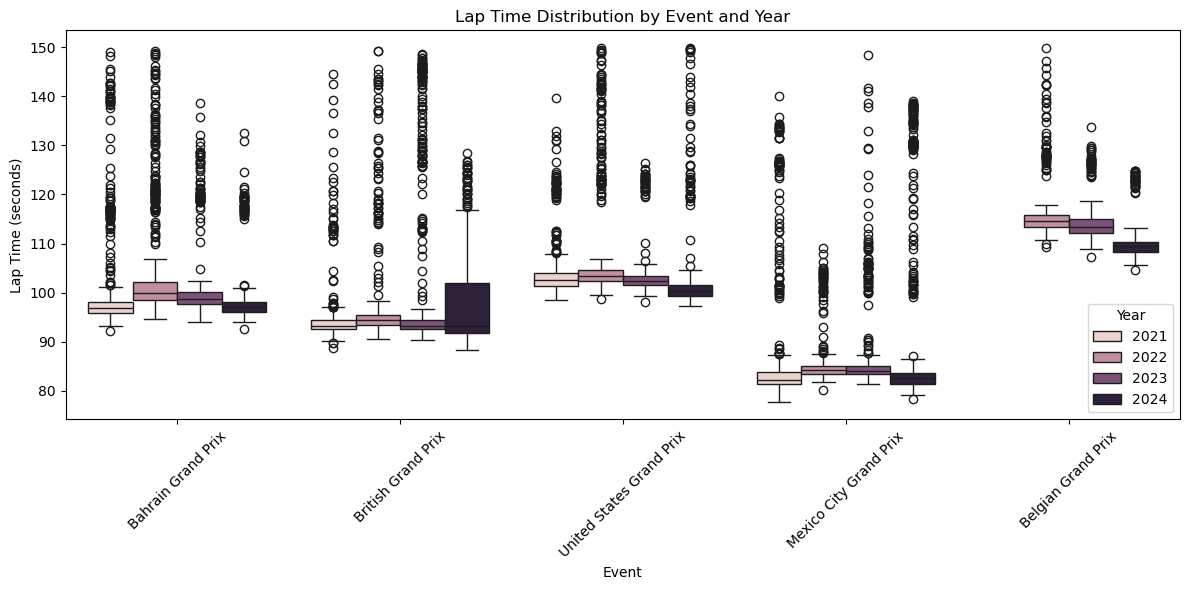

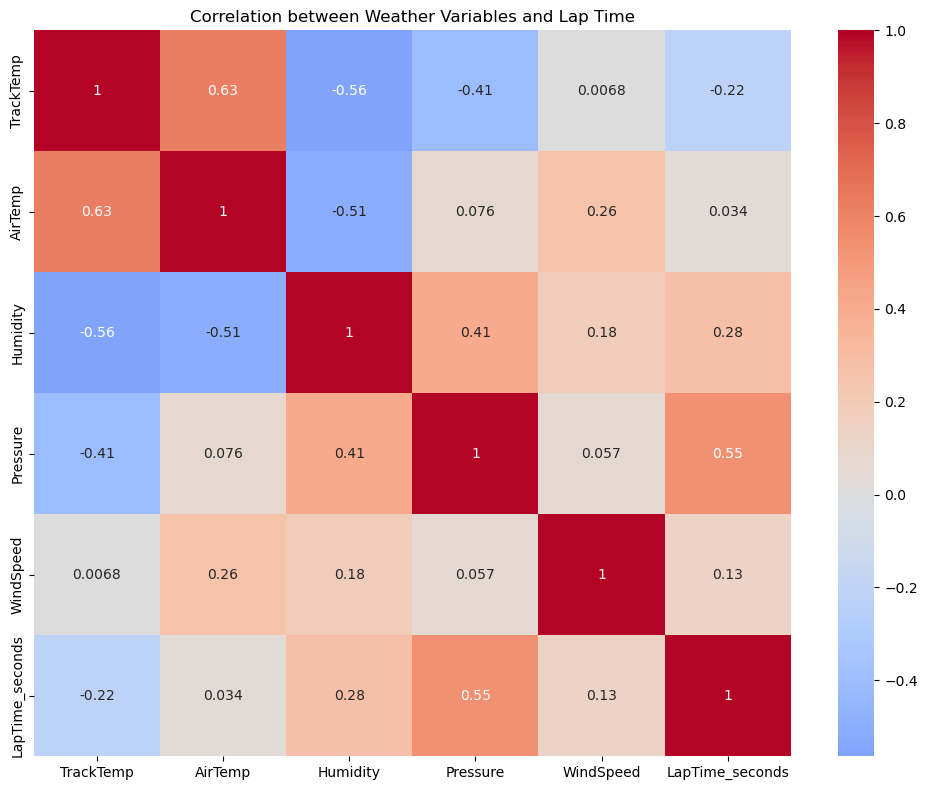

In [19]:
# Set up the plotting style
plt.rcParams['figure.figsize'] = [12, 6]

# 1. Lap Time Distribution by Event
plt.figure(figsize=(12, 6))
sns.boxplot(data=lap_data_combined, x='Event', y='LapTime_seconds')
plt.xticks(rotation=45)
plt.title('Lap Time Distribution by Event')
plt.xlabel('Event')
plt.ylabel('Lap Time (seconds)')
plt.tight_layout()
plt.show()

# 2. Weather Conditions Impact
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
sns.scatterplot(data=merged_data, x='TrackTemp', y='LapTime_seconds', ax=axes[0,0])
axes[0,0].set_title('Track Temperature vs Lap Time')

sns.scatterplot(data=merged_data, x='AirTemp', y='LapTime_seconds', ax=axes[0,1])
axes[0,1].set_title('Air Temperature vs Lap Time')

sns.scatterplot(data=merged_data, x='Humidity', y='LapTime_seconds', ax=axes[1,0])
axes[1,0].set_title('Humidity vs Lap Time')

sns.scatterplot(data=merged_data, x='WindSpeed', y='LapTime_seconds', ax=axes[1,1])
axes[1,1].set_title('Wind Speed vs Lap Time')
plt.tight_layout()
plt.show()

# 3. Driver Performance Comparison
plt.figure(figsize=(15, 6))
sns.boxplot(data=lap_data_combined, x='Driver', y='LapTime_seconds')
plt.xticks(rotation=45)
plt.title('Lap Time Distribution by Driver')
plt.xlabel('Driver')
plt.ylabel('Lap Time (seconds)')
plt.tight_layout()
plt.show()

# 4. Lap Time Evolution Over Race
plt.figure(figsize=(12, 6))
sns.lineplot(data=lap_data_combined, x='LapNumber', y='LapTime_seconds', hue='Driver')
plt.title('Lap Time Evolution During Race')
plt.xlabel('Lap Number')
plt.ylabel('Lap Time (seconds)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# 5. Track Temperature Changes
plt.figure(figsize=(12, 6))
sns.lineplot(data=weather_data_combined, x='Time', y='TrackTemp', hue='Event')
plt.title('Track Temperature Evolution')
plt.xlabel('Time')
plt.ylabel('Track Temperature (°C)')
plt.xticks(rotation=45)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# 6. Tire Compound Impact
plt.figure(figsize=(10, 6))
sns.boxplot(data=lap_data_combined, x='Compound', y='LapTime_seconds')
plt.title('Lap Time Distribution by Tire Compound')
plt.xlabel('Tire Compound')
plt.ylabel('Lap Time (seconds)')
plt.tight_layout()
plt.show()

# 7. Year-over-Year Comparison
plt.figure(figsize=(12, 6))
sns.boxplot(data=lap_data_combined, x='Event', y='LapTime_seconds', hue='Year')
plt.xticks(rotation=45)
plt.title('Lap Time Distribution by Event and Year')
plt.xlabel('Event')
plt.ylabel('Lap Time (seconds)')
plt.tight_layout()
plt.show()

# 8. Weather Correlation Heatmap
weather_vars = ['TrackTemp', 'AirTemp', 'Humidity', 'Pressure', 'WindSpeed', 'LapTime_seconds']
correlation = merged_data[weather_vars].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation between Weather Variables and Lap Time')
plt.tight_layout()
plt.show()

## Modeling Approach
This is primarily a regression problem as we're predicting continuous lap times. We plan to use:

1. Basic Models:
   - Linear Regression (baseline)
   - Random Forest Regression
   - XGBoost

2. Advanced Techniques:
   - Cross-validation for model evaluation
   - Hyperparameter tuning

Challenges:
1. Handling weather variability
2. Accounting for track-specific characteristics
3. Dealing with different race conditions

Project Milestones:
1. Data Collection & Cleaning (Complete)
2. EDA & Feature Engineering (Complete)
3. Initial Model Development (Dec 1)
4. Model Optimization (Dec 4)
5. Final Report Preparation (Dec 8)
6. Video Presentation (Dec 12)

## Project Goals and Expected Outcomes

Primary Objectives:
1. Create accurate lap time prediction models
2. Understand key factors affecting F1 performance
3. Develop insights for race strategy optimization

Hypotheses:
1. Weather conditions significantly impact lap times
2. Track temperature has a non-linear relationship with performance
3. Different drivers show varying sensitivity to weather conditions

Success Metrics:
- RMSE < 2 seconds for lap time predictions
- R² > 0.8 for our best model
- Meaningful insights into weather-performance relationships